In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import os; os.chdir("..")
import pqr
os.chdir("examples/")

## Считываем данные

In [4]:
prices = pd.read_excel('factors/italy/price.xlsx', index_col=0, parse_dates=True)
index = pd.read_excel('factors/italy/benchmark.xlsx', index_col=0, parse_dates=True)['CLOSE']

pe = pd.read_excel('factors/italy/mults/pe.xlsx', index_col=0, parse_dates=True)
mcap = pd.read_excel('factors/italy/financials/market_cap.xlsx', index_col=0, parse_dates=True)
volume = pd.read_excel('factors/italy/liquidity/volume.xlsx', index_col=0, parse_dates=True)

prices, index, pe, mcap, volume = pqr.utils.replace_with_nan(prices, index, pe, mcap, volume)

## Создаем на основе данных факторы

In [7]:
universe = pqr.Universe(prices)
universe.filter(volume >= 2_000_000)

preprocessor = [
    pqr.Filter(universe.mask),
    pqr.LookBackMean(3),
    pqr.Hold(3),
]

value = pqr.Factor(pe, better="less", preprocessor=preprocessor)
size = pqr.Factor(mcap, better="less", preprocessor=preprocessor)

benchmark = pqr.Benchmark.from_index(index, name="FTSE MIB")

## "Обучаем" факторную модель.

In [8]:
fm = pqr.fm.FactorModel(
    picking_strategies=[
        pqr.fm.Quantiles(0, 1/3),
        pqr.fm.Quantiles(1/3, 2/3),
        pqr.fm.Quantiles(2/3, 1),
    ],
    allocation_strategy=[pqr.EqualWeights(), pqr.CashAllocation(prices, capital=100_000, fee=0.0005)],
    add_wml=True
)

portfolios = fm(value, universe)

## После обучения у факторной модели появились портфели. С ними можно работать по отдельности

In [9]:
portfolios[0].returns

Winners
2016-04-30    0.000000
2016-05-31   -0.049913
2016-06-30   -0.184381
2016-07-31    0.113681
2016-08-31   -0.008188
                ...   
2020-12-31   -0.018295
2021-01-31   -0.016828
2021-02-28    0.132461
2021-03-31    0.111447
2021-04-30   -0.000076
Length: 61, dtype: float64

In [10]:
pqr.metrics.Alpha(benchmark, statistics=True)(portfolios[0])

Alpha(value=-0.06887880303229438, t_stat=-1.0492971997865441, p_value=0.2983206181334636)

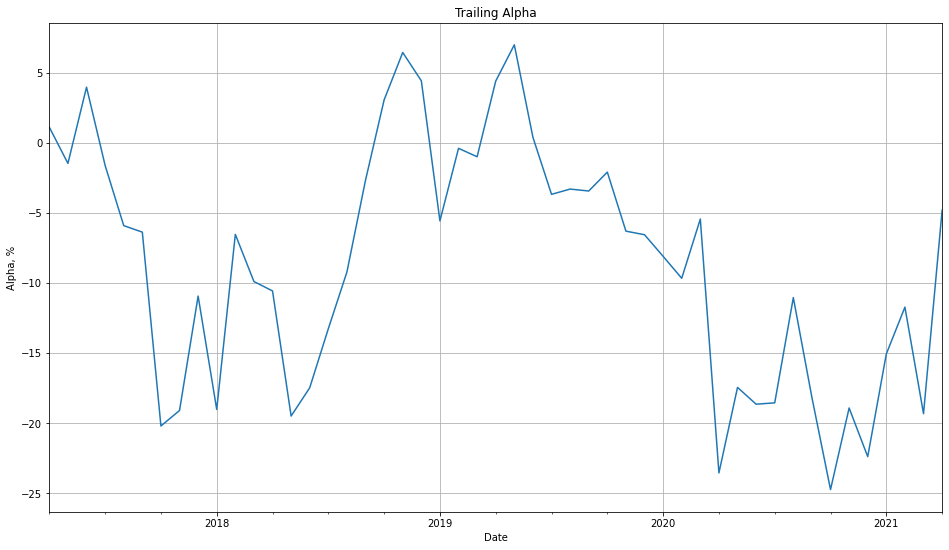

In [11]:
(pqr.metrics.TrailingAlpha(benchmark)(portfolios[0]) * 100).plot()

plt.title("Trailing Alpha")
plt.xlabel("Date")
plt.ylabel("Alpha, %")
plt.grid();

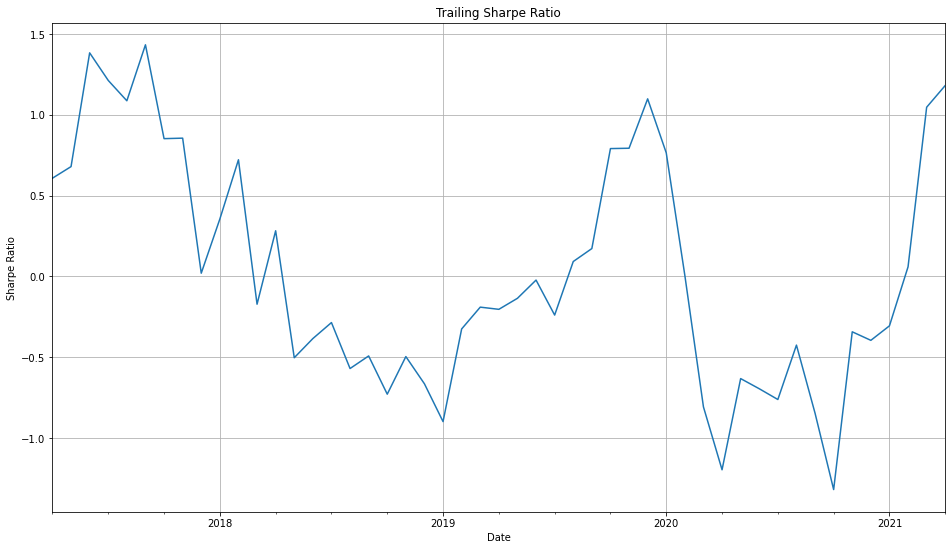

In [12]:
pqr.metrics.TrailingSharpeRatio()(portfolios[0]).plot()

plt.title("Trailing Sharpe Ratio")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid();

In [13]:
pqr.metrics.MaxDrawdown()(portfolios[0])

-0.53316035231527

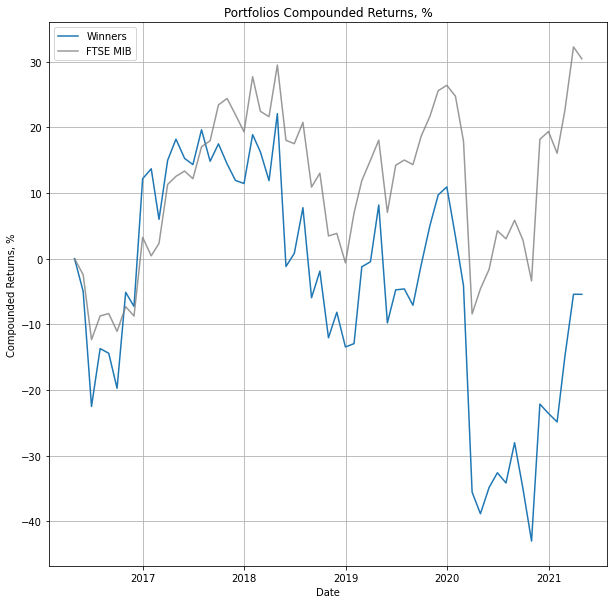

In [14]:
pqr.dash.Graph(
    pqr.metrics.CompoundedReturns(),
    benchmark,
    log_scale=False
)([portfolios[0]])

## Сравниваем портфели 

,Winners,Neutral 1,Losers,WML
"Mean Return, %",0.43 (0.33),1.13* (1.46),-0.10 (-0.13),0.53 (0.65)
"Volatility, %",10.25,6.05,6.18,6.42
Sharpe Ratio,0.15,0.65,-0.06,0.29
"Mean Excess Return, %",-2.35,6.07,-8.76,-1.12
"Alpha, %",-6.17 (-0.95),7.14 (1.59),-7.82* (-1.70),1.65 (0.21)
Beta,1.51,0.86,0.88,0.63


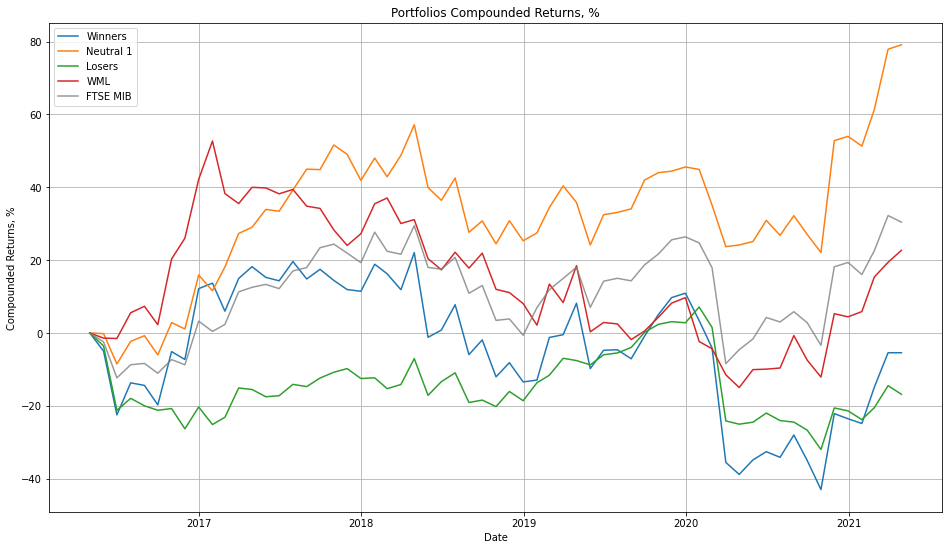

In [16]:
summary = pqr.dash.Dashboard(
    pqr.dash.Table(
        pqr.metrics.MeanReturn(annualizer=1, statistics=True),
        pqr.metrics.Volatility(annualizer=1),
        pqr.metrics.SharpeRatio(rf=0),
        pqr.metrics.MeanExcessReturn(benchmark),
        pqr.metrics.Alpha(benchmark, statistics=True),
        pqr.metrics.Beta(benchmark),
    ),
    pqr.dash.Graph(pqr.metrics.CompoundedReturns(), benchmark=benchmark, figsize=(16, 9)),

)
summary(portfolios)

## grid_search

In [20]:
def preprocessor_mean_factory(looking, lag, holding):
    return [
        pqr.Filter(universe.mask),
        pqr.LookBackMean(looking),
        pqr.Lag(lag),
        pqr.Hold(holding)
    ]


param_grid = {
    "(1, 0, 1)": preprocessor_mean_factory(1, 0, 1),
    "(1, 1, 1)": preprocessor_mean_factory(1, 1, 1),
    "(3, 0, 3)": preprocessor_mean_factory(3, 0, 3),
    "(3, 1, 3)": preprocessor_mean_factory(3, 1, 3),
    "(6, 0, 6)": preprocessor_mean_factory(6, 0, 6),
    "(6, 1, 6)": preprocessor_mean_factory(6, 1, 6),
    "(9, 0, 9)": preprocessor_mean_factory(9, 0, 9),
    "(9, 1, 9)": preprocessor_mean_factory(9, 1, 9),
    "(12, 0, 12)": preprocessor_mean_factory(12, 0, 12),
    "(12, 1, 12)": preprocessor_mean_factory(12, 1, 12),
}

gs = pqr.fm.GridSearch(
    factor_preprocessors=param_grid,
    factor_model=fm
)

value_raw = pqr.Factor(pe, better="less")

results = gs(
    factor=value_raw,
    universe=universe,
    target=pqr.metrics.Alpha(benchmark)
)

In [21]:
results

,Winners,Neutral 1,Losers,WML
"(1, 0, 1)",-0.049373,0.004987,0.031886,-0.081249
"(1, 1, 1)",-0.046116,0.015450,-0.020108,-0.026010
"(3, 0, 3)",-0.061723,0.071360,-0.078208,0.016515
"(3, 1, 3)",-0.054360,0.069524,-0.062883,0.008536
"(6, 0, 6)",-0.055019,-0.001306,0.011297,-0.066319
"(6, 1, 6)",-0.056017,-0.029571,0.036029,-0.092038
"(9, 0, 9)",-0.087147,-0.026815,0.024427,-0.111559
"(9, 1, 9)",-0.064466,-0.006425,0.042197,-0.106659
"(12, 0, 12)",-0.035067,-0.000403,0.038904,-0.073952
"(12, 1, 12)",-0.057829,-0.010990,0.043956,-0.101781


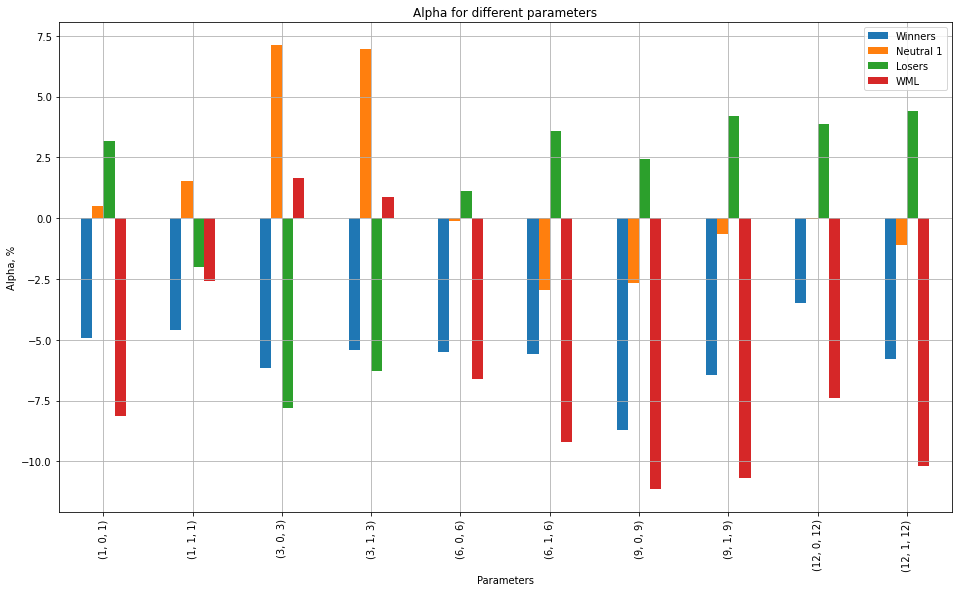

In [22]:
(results * 100).plot.bar()
plt.title("Alpha for different parameters")
plt.xlabel("Parameters")
plt.ylabel("Alpha, %")
plt.grid();

# zero_intelligence_test

In [23]:
best_portfolio = portfolios[2]

In [24]:
%%time
%%capture

zi = pqr.tests.ZeroIntelligenceTest(
    universe,
    pqr.EqualWeights(),
    pqr.metrics.TrailingMeanReturn(),
    n=1000
)

zi_est = zi(best_portfolio)

CPU times: user 3.69 s, sys: 5.6 ms, total: 3.69 s
Wall time: 3.69 s


In [25]:
zi_est

Losers
2017-04-30    0.017
2017-05-31    0.003
2017-06-30    0.011
2017-07-31    0.019
2017-08-31    0.038
2017-09-30    0.024
2017-10-31    0.191
2017-11-30    0.247
2017-12-31    0.698
2018-01-31    0.687
2018-02-28    0.451
2018-03-31    0.392
2018-04-30    0.561
2018-05-31    0.870
2018-06-30    0.947
2018-07-31    0.882
2018-08-31    0.927
2018-09-30    0.844
2018-10-31    0.826
2018-11-30    0.806
2018-12-31    0.785
2019-01-31    0.979
2019-02-28    0.909
2019-03-31    0.953
2019-04-30    0.805
2019-05-31    0.884
2019-06-30    0.727
2019-07-31    0.808
2019-08-31    0.822
2019-09-30    0.858
2019-10-31    0.714
2019-11-30    0.632
2019-12-31    0.591
2020-01-31    0.724
2020-02-29    0.925
2020-03-31    0.649
2020-04-30    0.746
2020-05-31    0.369
2020-06-30    0.382
2020-07-31    0.345
2020-08-31    0.142
2020-09-30    0.292
2020-10-31    0.349
2020-11-30    0.128
2020-12-31    0.145
2021-01-31    0.025
2021-02-28    0.010
2021-03-31    0.005
2021-04-30    0.005
dtype: float6

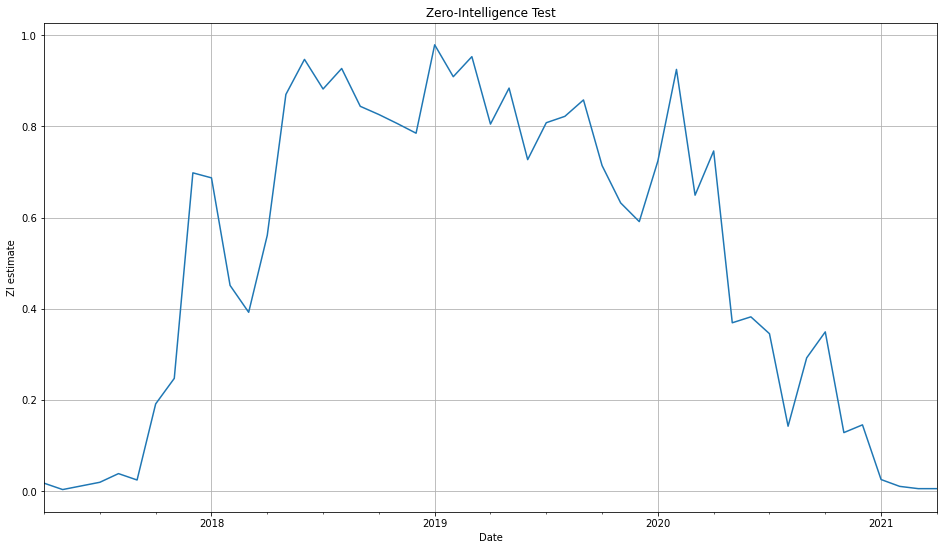

In [26]:
zi_est.plot()

plt.title("Zero-Intelligence Test")
plt.xlabel("Date")
plt.ylabel("ZI estimate")
plt.grid();